In [98]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import distance
import math
import random
from IPython.display import display

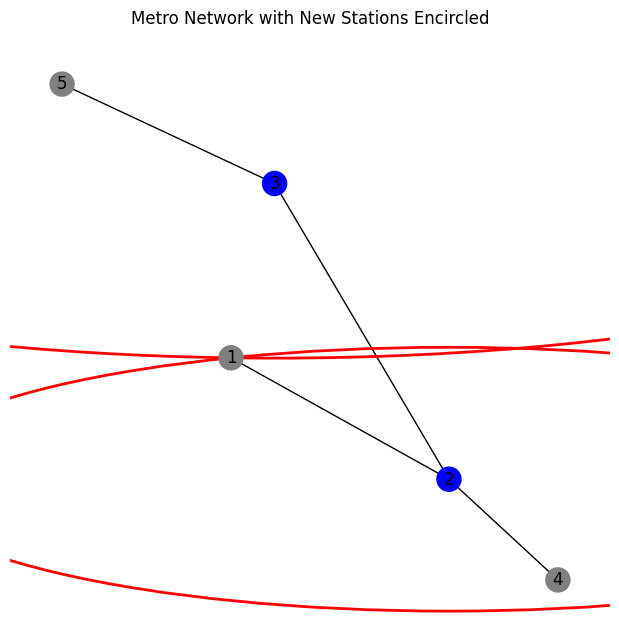

In [96]:
# Create the graph
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_edges_from([(1, 2, {'label': "A"}),
                  (2, 3, {'label': "A"}),
                  (2, 4, {'label': "B"}),
                  (3, 5, {'label': "C"})])

# Station coordinates
station_coordinates = {
    1: (48.8566, 2.3522),
    2: (48.8606, 2.3428),
    3: (48.8574, 2.3657),
    4: (48.8626, 2.3350),
    5: (48.8535, 2.3734),
}

# Classify stations
old_stations = {1, 4, 5}  # Example old stations
new_stations = {2, 3}  # Example new stations
m = 2  # Number of old stations per circle

# Assign random traffic values to old nodes only
for node in G.nodes():
    if node in old_stations:  # Check if the node is an old station
        G.nodes[node]['traffic'] = random.randint(1, 100)  # Generate random traffic between 1 and 10 (inclusive)

# Store original traffic values
original_traffic = {node: G.nodes[node].get('traffic', 0) for node in G.nodes()}

# Compute distance between new stations and old stations
def find_nearest_old_stations(new_station, m):
    new_coord = station_coordinates[new_station]
    distances = [(old, distance.euclidean(new_coord, station_coordinates[old])) for old in old_stations]
    distances.sort(key=lambda x: x[1])  # Sort by distance
    return [station for station, _ in distances[:m]]

# Redistribute traffic from old stations to new stations within circles
for new_station in new_stations:
    # Find old stations within the circle
    nearest_old_stations = find_nearest_old_stations(new_station, m)

    # Calculate traffic to be redistributed
    traffic_to_redistribute = 0
    for old_station in nearest_old_stations:
        traffic_to_redistribute += G.nodes[old_station]['traffic'] / (m + 1)

    # Redistribute traffic
    G.nodes[new_station]['traffic'] = traffic_to_redistribute
    for old_station in nearest_old_stations:
        G.nodes[old_station]['traffic'] -= G.nodes[old_station]['traffic'] / (m + 1)

# Visualization
plt.figure(figsize=(6, 6))
pos = {station: (coord[0], coord[1]) for station, coord in station_coordinates.items()}
nx.draw(G, pos, with_labels=True, node_color=["blue" if n in new_stations else "gray" for n in G.nodes], edge_color='black')

def meters_to_degrees(meters, latitude):
  """Converts meters to degrees of latitude at a given latitude."""
  return meters / (111.32 * 1000 * math.cos(math.radians(latitude)))

# Draw circles around new stations
for new_station in new_stations:
    nearest_old = find_nearest_old_stations(new_station, m)
    old_coords = [station_coordinates[old] for old in nearest_old]
    new_coord = station_coordinates[new_station]

    # Compute radius as the max distance to an old station
    radius = max(distance.euclidean(new_coord, old) for old in old_coords)

    # Draw circle
    circle = plt.Circle((new_coord[0], new_coord[1]), radius, color='red', fill=False, linewidth=2)
    plt.gca().add_patch(circle)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Metro Network with New Stations Encircled")
plt.show()

In [97]:
# Create a DataFrame for the table
data = []
for node in G.nodes():
    original = original_traffic[node]
    new = G.nodes[node].get('traffic', 0)
    data.append([node, original, new])

df = pd.DataFrame(data, columns=['Station ID', 'Original Traffic', 'New Traffic'])

# Display the table
display(df)

,Station ID,Original Traffic,New Traffic
0,1,100,44.444444
1,2,0,40.000000
2,3,0,48.555556
3,4,20,13.333333
4,5,79,52.666667
